# LeNet

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [2]:
import letter_detection_utils as ld_util
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(ld_util)

<module 'letter_detection_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/letter_detection/letter_detection_utils.py'>

In [3]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    # pickle_name='ld_sobel_y', 
    img_size=img_size,
    with_edge_detection = False
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Loading existing data from  ../../pickle/letter_detection_data.pickle ...
Length:  1000
Imgs length:  1000
Img shape:  (4096,)


# Model

In [4]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

In [5]:
X_train_lenet = X_train.reshape(-1, img_size[0], img_size[1], 1)
X_test_lenet = X_test.reshape(-1, img_size[0], img_size[1], 1)

X_train_lenet.shape

(800, 32, 128, 1)

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical

In [7]:
inputs = Input(shape=(X_train_lenet.shape[1], X_train_lenet.shape[2],  X_train_lenet.shape[3]))
conv_1 = Conv2D(filters = 32,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                activation = 'relu')             # Fonction d'activation
max_pool_1 = MaxPooling2D(pool_size = (2, 2))
conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')
max_pool_2 = MaxPooling2D(pool_size = (2, 2))
flatten = Flatten()
dropout = Dropout(rate = 0.2)
dense_1 = Dense(units = 128,
                activation = 'relu')
dense_2 = Dense(units = df['length'].max(),
                activation = 'softmax')

outputs=conv_1(inputs)
outputs=max_pool_1(outputs)
outputs=conv_2(outputs)
outputs=max_pool_2(outputs)
outputs=dropout(outputs)
outputs=flatten(outputs)
outputs=dense_1(outputs)
outputs=dense_2(outputs)

In [8]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation
nb_epochs = 16

training_history_lenet = lenet.fit(X_train_lenet, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = nb_epochs,               # nombre d'epochs
                                   batch_size = 20)          # taille des batchs

Epoch 1/16


2023-02-22 21:27:23.149172: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


32/32 [==============================] - 1s 22ms/step - loss: 2.3248 - accuracy: 0.1578 - val_loss: 2.2414 - val_accuracy: 0.1813
Epoch 2/16
32/32 [==============================] - 1s 21ms/step - loss: 2.2141 - accuracy: 0.1922 - val_loss: 2.2296 - val_accuracy: 0.1813
Epoch 3/16
32/32 [==============================] - 1s 18ms/step - loss: 2.1916 - accuracy: 0.2141 - val_loss: 2.1900 - val_accuracy: 0.1875
Epoch 4/16
32/32 [==============================] - 1s 17ms/step - loss: 2.1375 - accuracy: 0.2109 - val_loss: 2.1222 - val_accuracy: 0.2250
Epoch 5/16
32/32 [==============================] - 1s 18ms/step - loss: 2.0336 - accuracy: 0.2703 - val_loss: 2.0182 - val_accuracy: 0.2812
Epoch 6/16
32/32 [==============================] - 1s 16ms/step - loss: 1.9366 - accuracy: 0.2984 - val_loss: 2.1090 - val_accuracy: 0.2812
Epoch 7/16
32/32 [==============================] - 0s 15ms/step - loss: 1.8789 - accuracy: 0.3453 - val_loss: 2.0968 - val_accuracy: 0.2812
Epoch 8/16
32/32 [======

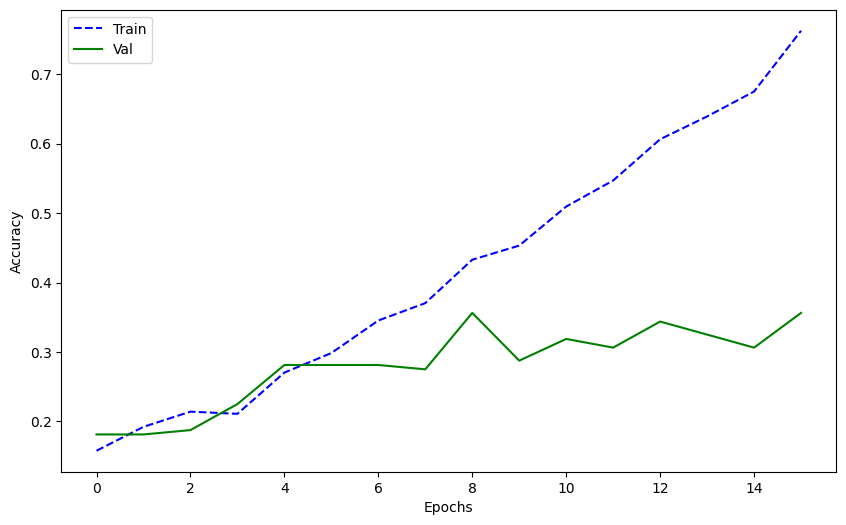

In [12]:
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

plt.figure(figsize=(10,6))
xaxis = range(nb_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(xaxis,
         train_acc_lenet, 
         label = 'Train',
         ls='--',
         color = 'blue')
plt.plot(xaxis,
         val_acc_lenet, 
         label = 'Val',
         color = 'green')
plt.legend()
plt.show()

We see that our model completely fail to guess the number of letters in a word. The training evaluation keeps getting better, whereas the validation data stagnates. We are overfitting.  

In [10]:
y_pred_lenet = lenet.predict(X_test_lenet)

7/7 [==============================] - 0s 5ms/step


# Taking an example out of the test

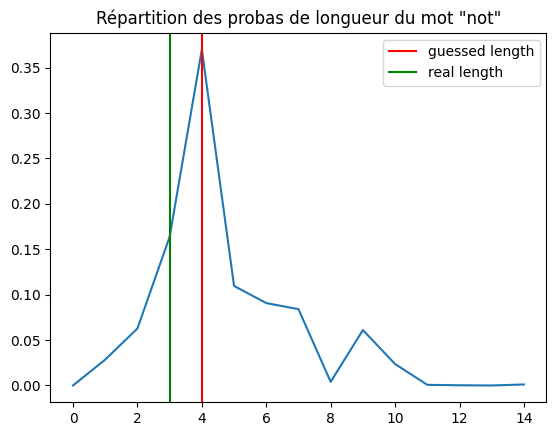

In [15]:
plt.plot(range(df['length'].max()), y_pred_lenet[0]);
plt.axvline(y_pred_lenet[0].argmax(), color='red', label='guessed length');
plt.axvline(df.iloc[0 + len(X_train_lenet)].length, color='green', label='real length');
plt.legend()
plt.title('Répartition des probas de longueur du mot "' + df.iloc[0+ len(X_train_lenet)].transcription + '"');